# Classifier drift detector on CIFAR-10

### Method

The classifier-based drift detector simply tries to correctly classify instances from the reference data vs. the test set. If the classifier does not manage to significantly distinguish the reference data from the test set according to a chosen metric (defaults to the classifier accuracy), then no drift occurs. If it can, the test set is different from the reference data and drift is flagged. To leverage all the available reference and test data, stratified cross-validation can be applied and the out-of-fold predictions are used to compute the drift metric. Note that a new classifier is trained for each test set or even each fold within the test set.

### Dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32 by 32 RGB images equally distributed over 10 classes. We evaluate the drift detector on the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)). The instances in
CIFAR-10-C have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in the classification model performance. We also check for drift against the original test set with class imbalances. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input

from alibi_detect.cd import ClassifierDrift
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

Importing plotly failed. Interactive plots will not work.


### Load data

Original CIFAR-10 data:

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

For CIFAR-10-C, we can select from the following corruption types at 5 severity levels:

In [4]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


Let's pick a subset of the corruptions at corruption level 5. Each corruption type consists of perturbations on all of the original test set images.

In [5]:
# corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
corruption = ['gaussian_noise']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

We split the original test set in a reference dataset and a dataset which should not be flagged as drift. We also split the corrupted data by corruption type:

In [6]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3)


In [7]:
X_c = []
n_corr = len(corruption)
for i in range(n_corr):
    X_c.append(X_corr[i * n_test:(i + 1) * n_test])

We can visualise the same instance for each corruption type:

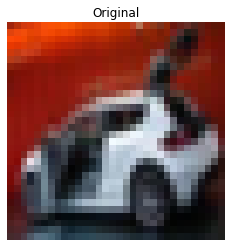

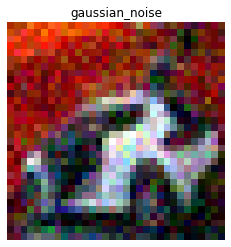

In [8]:
i = 6

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

### Detect drift

We use a simple classification model and try to distinguish between the reference data and the corrupted test sets. Initially we'll test at a significance level of $p=0.05$, use $75$% of the shuffled reference and test data for training and evaluate the detector on the remaining $25$%. We only train for 1 epoch.

In [9]:
tf.random.set_seed(0)

model = tf.keras.Sequential(
  [
      Input(shape=(32, 32, 3)),
      Conv2D(8, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(16, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(32, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(2, activation='softmax')
  ]
)

cd = ClassifierDrift(p_val=.05, model=model, X_ref=X_ref, train_size=.75, epochs=1)

# we can also save/load an initialised detector
filepath = 'my_path'  # change to directory where detector is saved
save_detector(cd, filepath)
cd = load_detector(filepath)

No model found in my_path/model.


In [10]:
preds_h0 = cd.predict(X_h0)

labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))

Drift? No!


As expected, no drift occurred. The p-value of the K-S test being performed under the hood is way above the 0.05 threshold.

In [12]:
print(f"p_val: {preds_h0['data']['p_val']} -- threshold: {preds_h0['data']['threshold']}")

p_val: 0.5560398731282864 -- threshold: 0.05


Let's now check the predictions on the corrupted data:

In [14]:
for x, c in zip(X_c, corruption):
    preds = cd.predict(x)
    print(f'Corruption type: {c}')
    print(f"Drift? {labels[preds['data']['is_drift']]}")
    print(f"p-val: {preds['data']['p_val']}")
    print('')

Corruption type: gaussian_noise
Drift? Yes!
p-val: 0.0



The classifier could easily distinguish the corrupted from the reference data.

### Use all the available data

So far we've only used $25$% of the data to detect the drift since $75$% is used for training purposes. At the cost of additional training time we can however leverage all the data via stratified cross-validation. We just need to set the number of folds and keep everything else the same. So for each test set `n_folds` models are trained, and the out-of-fold predictions combined for the test.

In [15]:
cd = ClassifierDrift(p_val=.05, model=model, X_ref=X_ref, n_folds=5, epochs=1)

Both `n_folds` and `train_size` specified. By default `n_folds` is used.


In [16]:
for x, c in zip(X_c, corruption):
    preds = cd.predict(x)
    print(f'Corruption type: {c}')
    print(f"Drift? {labels[preds['data']['is_drift']]}")
    print(f"p-val: {preds['data']['p_val']}")
    print('')

Corruption type: gaussian_noise
Drift? Yes!
p-val: 0.0



In [17]:
preds_h0 = cd.predict(X_h0)
print(f"Drift? {labels[preds_h0['data']['is_drift']]}")
print(f"p-val: {preds_h0['data']['p_val']}")

Drift? No!
p-val: 0.6670001763077853
